# Introduction to this notebook

In recent times, we have seen many successful applications of Machine Learning aided Couputer Vision in health and diagnostics. Interestingly, amongst severel methods in computer vision, image classification stays on the [top](https://skywell.software/blog/top-6-computer-vision-techniques-and-algorithms).

In this notebook, I have used [dataset](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia) available at Kaggle to build an X-ray image classification model. This Dataset has been carefully screened by 3 medical experts and is also part of the [research article](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) published in the [*Cell*](https://www.cell.com/), a reputed journal of the field. 

This notebook covers the steps required from loading of the datasets (downloaded and available on PC) to the predicting of the results of model. The model obtained in the process is able to classify the X-ray images into normal/healthy or presence of [pneumonia](https://en.wikipedia.org/wiki/Pneumonia). This was also interesting topic to work on as the [COVID-19](https://en.wikipedia.org/wiki/COVID-19) patients develop Pneumonia.

The notebook starts with loading of necessary packages(modules), followed by loading of image data, balancing of the image data (we talk about this later), building-training a basic convolutional neural network model. Fine tuning the obtained model, followed by the prediction on the unknown datasets. We are not including the [data augmentation](https://en.wikipedia.org/wiki/Data_augmentation) step while building our model, because it involves flips, rotations, zooming: which does not work on the type of images we are working on. X-ray images needs to be in particular orientation.

Disclaimer: 
1. Source of inspiration comes from a [previous work](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays) on the classification of X-ray images for pneumonia-infected/healthy lungs.

2. This notebook is the part of the final project that I am working on at the WBS Coding School, Berlin, Germany.

3. This notebook only classifies the normal X-ray images to abnormal, and it does not classifies the pathogenesis behind the abnormality.

4. Machine learning/computer vision results are dependant on the quality of the model and its training on the available datasets. The results obtained here should not be considered as final diagnostic measure. Health care professional should be approached on time, who can infer the X-ray together with other laboratory tests.   

# Step 1: Loading of necessary liberaries

In the very first step, we need to install [Tensorflow](https://www.tensorflow.org/). We do this using [Pip](https://pypi.org/project/pip/), a package installer for Python.

In [ ]:
!pip install tensorflow-gpu

Next we import necessary liberaries for making this notebook functional.

In [2]:
import re                                               #for regular expression operations
import os                                               #for operating system interactions
import PIL                                              #for image processing
import numpy as np                                      #for working with arrays
import pandas as pd                                     #for data analysis & manipulation
import tensorflow as tf                                 #for machine learning & AI
from tensorflow import keras                            #for interface to TensorFlow liberaries 
from tensorflow.keras import layers                     #for building blocks of neural networks
from tensorflow.keras.models import Sequential          #for using sequential model within Keras
from sklearn.model_selection import train_test_split    #for splitting the data into train test sets
import matplotlib.pyplot as plt                         #for data visualization & plots

# Step 2: Setting the variables and configurations

In [4]:
if tf.config.list_physical_devices("GPU"):
  strategy = tf.distribute.MirroredStrategy()
else:  # Use the Default Strategy
  strategy = tf.distribute.get_strategy()

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 11

class_path = "C:/Users/sabah/deep-learning/chest_xray/train/*"
train_path = "C:/Users/sabah/deep-learning/chest_xray/train/*/*.jpeg"
valid_path = "C:/Users/sabah/deep-learning/chest_xray/val/*/*.jpeg"
tests_path = "C:/Users/sabah/deep-learning/chest_xray/test/*/*.jpeg"

In above cell, batch size refers to the number of samples processed before the model is updated and the number of epochs represents the number of passes that have been made through the training dataset. While setting the number of epochs we chose `11` because that is optimal number of epochs to train a neural network as reported [previously](https://www.geeksforgeeks.org/choose-optimal-number-of-epochs-to-train-a-neural-network-in-keras/). 

I have used batch size of `16`, as it is [recommended](https://www.surfactants.net/how-to-choose-batch-size-and-epochs-tensorflow/) starting point. Moreover, batch size of `32` or smaller should be considered to train neural networks. Large batch sizes are not recommended because the data may overfit.

# Step 3: Load and split the data

The Datasets which I have has been already divided into the training (train), validation (val), and test folders. Since the validation folder contains just 16 files, we can simple append it to the training set, before we split the datasets in training and test. The spliting ratio is 80:20.

In [5]:
files = tf.io.gfile.glob(str(train_path))
files.extend(tf.io.gfile.glob(str(valid_path)))

train_files, val_files = train_test_split(files, test_size=0.20)

Next, we check how many healthy/normal chest X-rays we have and how many pneumonia chest X-rays we have. We can also verify here if the splitting of data in the selected ratio (80:20) worked correctly. 

For this we run the following cell:

In [6]:
train_normal_cnt = len([filename for filename in train_files if "NORMAL" in filename])
train_pneumonia_cnt = len([filename for filename in train_files if "PNEUMONIA" in filename])
val_normal_cnt = len([filename for filename in val_files if "NORMAL" in filename])
val_pneumonia_cnt = len([filename for filename in val_files if "PNEUMONIA" in filename])
total_train_cnt = train_normal_cnt + train_pneumonia_cnt
total_val_cnt = val_normal_cnt + val_pneumonia_cnt

print("\n1. There are in total " + str(total_train_cnt + total_val_cnt) + " X-ray images")
print("\n2. Training set comprises of total " + str(total_train_cnt) + " X-ray images, of which " +  str(train_normal_cnt) + " are normal X-ray images and " +  str(train_pneumonia_cnt) + " are pneumonia X-ray images.")
print("\n3. Validation set comprises of total " + str(total_val_cnt) + " X-ray images, of which " +  str(val_normal_cnt) + " are normal X-ray images and " +  str(val_pneumonia_cnt) + " are pneumonia X-ray images.")


1. There are in total 5232 X-ray images

2. Training set comprises of total 4185 X-ray images, of which 1070 are normal X-ray images and 3115 are pneumonia X-ray images.

3. Validation set comprises of total 1047 X-ray images, of which 279 are normal X-ray images and 768 are pneumonia X-ray images.


On careful observation, we notice that there there is an imbalance in our datasets, as there are much more images for pneumonia than normal. This needs to be corrected before we start the training of the model.

# Step 4: Format, load, and explore the datasets

In [7]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_files)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_files)

class_names = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(class_path))])
    
print("There are following classes/labels in the datasets: " + str(class_names))

There are following classes/labels in the datasets: ['NORMAL' 'PNEUMONIA']


We found that there are two labels: `Normal` and `Pneumonia`.

At present stage, the datasets are just a list of filenames and we need to map each filename to the corresponding image, as well the label pair. Since we have ony two labes, we re-write the label as such that the `1` or `True` corresponds to the `pneumonia` X-ray, while `0` or `False` corresponds to the `normal` X-ray.

In [8]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    return parts[-2] == "PNEUMONIA"

Above cell fetches the file path

In [9]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, IMAGE_SIZE)

Above cell converts/encodes the images to desired size and features

In [10]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

Above cell process the path, and in the cell below we define "where" is training dataset and validation dataset

In [11]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

Next we also visualize the shape of an (image, label) pair.

In [12]:
for image, label in train_ds.take(5):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  True
Image shape:  (180, 180, 3)
Label:  False


Above cell provides information of 5 images: their shape and Label. False corresponds to image for normal lungs and True to vice versa  

In the following cell, we load the "test" datasets, and further explore (i.e., count the number of images in test datatsets)

In [13]:
test_list_ds = tf.data.Dataset.list_files(str(tests_path))
total_test_cnt = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print("There are " + str(total_test_cnt) + " images in the test dataset")

There are 624 images in the test dataset


# Step 5: Visualize the dataset

To prevent the I/O from blocking while retreive the data from disk, we are using here the buffered prefetching:

In [14]:
def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Iteration of the training data: next batch 

In [15]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

Show the images in the batch:

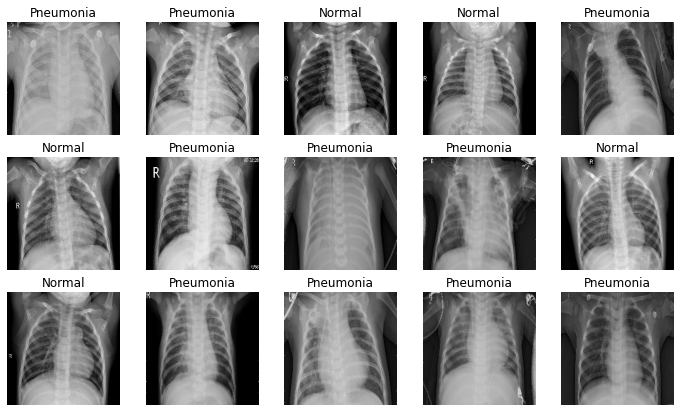

In [17]:
#define a method to show the images in the batch
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(12,12))
    for n in range(15):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("Pneumonia")
        else:
            plt.title("Normal")
        plt.axis("off")
        
#calling the numpy function        
show_batch(image_batch.numpy(), label_batch.numpy())

# Step 6: Build the Convolution Neural Network (CNN)

Since we are going to build CNN, we will create a convolution block and also a dense layer block.

The architecture for this CNN has been inspired by this [article](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8) and [previous work](https://www.kaggle.com/code/amyjang/tensorflow-pneumonia-classification-on-x-rays) on the classification of X-ray images for pneumonia-infected/healthy lungs.

In [18]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [19]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Define the function to build our model:

In [20]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

The Dropout layers "drop out" certain nodes to reduce the likelikhood of the model overfitting, therefore they are importnat component of this model. Model is ended with a "dense layer" of `1` node, as this will be the output which determines if an X-ray image belongs to pneumonia or not.

# Step 7: Corrections to fix the data imbalance in the dataset

The Dataset on which we are working, has more images classified pneumonia than normal. CNN works the best when the training data is balanced. Hence we will correct his imbalance using the following method: 

In [21]:
initial_bias = np.log([train_pneumonia_cnt/train_normal_cnt])
initial_bias

array([1.0685705])

In [22]:
weight_for_0 = (1 / train_normal_cnt)*(total_train_cnt)/2.0 
weight_for_1 = (1 / train_pneumonia_cnt)*(total_train_cnt)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for normal: {:.2f}'.format(weight_for_0))
print('Weight for pneumonia: {:.2f}'.format(weight_for_1))

Weight for normal: 1.96
Weight for pneumonia: 0.67


We see above that the weight for Normal class, `0` is a lot higher than the weight for Pneumonia class, `1`. This is simply because there are more number of pneumonia images, than the normal images. Therefore each normal image will be weighted more to balance the data.

# Step 8: Trainining the model

Here I  use the `binary_crossentropy` loss while training, because there are only two possible labels for the image, class `0` corresponding to normal, while class `1` corresponding to Pneumonia images.

-> `Accuracy` tells us what fractions of the labels are correct.

-> `Precision` is the number of true positives (TP) over the sum of TP and false positives (FP).

-> `Recall` is the number of TP over the sum of TP and false negatves (FN).

In [23]:
with strategy.scope():
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [24]:
history = model.fit(
    train_ds,
    steps_per_epoch=total_train_cnt // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=total_val_cnt // BATCH_SIZE,
    class_weight=class_weight,
)

Epoch 1/11
261/261 [==============================] - 255s 922ms/step - loss: 0.4018 - accuracy: 0.8091 - precision: 0.9477 - recall: 0.7871 - val_loss: 0.6704 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 2/11
261/261 [==============================] - 198s 759ms/step - loss: 0.2266 - accuracy: 0.9148 - precision: 0.9748 - recall: 0.9089 - val_loss: 1.2246 - val_accuracy: 0.7356 - val_precision: 0.7356 - val_recall: 1.0000
Epoch 3/11
261/261 [==============================] - 184s 704ms/step - loss: 0.1975 - accuracy: 0.9315 - precision: 0.9758 - recall: 0.9312 - val_loss: 0.1466 - val_accuracy: 0.9404 - val_precision: 0.9848 - val_recall: 0.9332
Epoch 4/11
261/261 [==============================] - 184s 704ms/step - loss: 0.1769 - accuracy: 0.9349 - precision: 0.9797 - recall: 0.9317 - val_loss: 0.1019 - val_accuracy: 0.9663 - val_precision: 0.9679 - val_recall: 0.9869
Epoch 5/11
261/261 [==============================] - 187s 715ms/step - loss: 0.1402 - a

# Step 9: Fine-tuning and saving of the best model

-> To further finetune obtained model, Keras callbacks is used.

-> Checkpoint callback saves the best weights of model. This saves time, which may be spent while training.

-> Early stopping callback stops the training process when the model stops improving.

-> The settings, `restore_best_weights` to `True`, returns model with low loss and high accuracy.

In [25]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("xray_model_v2.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(verbose=1, patience=10,
                                                     restore_best_weights=True)

Also there is a need to finetune the learning rate of model. High learning rate will cause the model to diverge, while low learning rate will cause the model to be too slow.

In [26]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [27]:
history = model.fit(
    train_ds,
    steps_per_epoch=total_train_cnt // BATCH_SIZE,
    epochs=100,
    validation_data=val_ds,
    validation_steps=total_val_cnt // BATCH_SIZE,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

Epoch 1/100
261/261 [==============================] - 245s 936ms/step - loss: 0.3723 - accuracy: 0.8484 - precision: 0.9421 - recall: 0.8484 - val_loss: 1.8618 - val_accuracy: 0.7462 - val_precision: 0.7437 - val_recall: 0.9987 - lr: 0.0100
Epoch 2/100
261/261 [==============================] - 219s 840ms/step - loss: 0.2681 - accuracy: 0.8879 - precision: 0.9652 - recall: 0.8815 - val_loss: 0.2494 - val_accuracy: 0.8952 - val_precision: 0.9780 - val_recall: 0.8765 - lr: 0.0089
Epoch 3/100
261/261 [==============================] - 215s 824ms/step - loss: 0.2348 - accuracy: 0.9011 - precision: 0.9717 - recall: 0.8932 - val_loss: 0.2327 - val_accuracy: 0.8981 - val_precision: 0.9838 - val_recall: 0.8757 - lr: 0.0079
Epoch 4/100
261/261 [==============================] - 245s 940ms/step - loss: 0.2757 - accuracy: 0.8855 - precision: 0.9639 - recall: 0.8787 - val_loss: 1.8797 - val_accuracy: 0.5250 - val_precision: 0.9963 - val_recall: 0.3547 - lr: 0.0071
Epoch 5/100
261/261 [===========

# Step 10: Loading saved model for re-improvement/evaluation

In [ ]:
# location of the saved model
path = "complete/path/to/the/model"
 
# fetch and load the model
trained_model = keras.models.load_model(path)